<a href="https://colab.research.google.com/github/sebastianoscarlopez/learning-deep-learning/blob/master/digits_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

Digits recognition it is called the Hello World of Neural Network.

Made using Python, numpy applied to MNIST dataset.

It example is based on http://neuralnetworksanddeeplearning.com/chap1.html

# Preparation

## Base libraries

In [0]:
%tensorflow_version 2.x

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Load data

**mnist_loader**

A library to load the MNIST image $28*28$ with digits

data stored on training_data (60%) test_data (10%), array image rearrange in vector of 784

In [0]:
from keras.datasets import mnist


unit vector with a 1.0 in the jth position and zeroes elsewhere.

Output layer are 10 neurons representing numbers from 0 to 9

In [0]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
training_inputs = [ np.reshape(x, (784, 1)) for x in x_train ]
training_results = [ vectorized_result(y) for y in y_train ]
training_data = list(zip(training_inputs, training_results))#list(map(lambda x, y: [x, y], training_inputs, training_results))
test_inputs = [ np.reshape(x, (784, 1)) for x in x_test ]
test_data = list(zip(test_inputs, y_test)) #list(map(lambda x, y: [x, y], test_inputs, y_test))

# Network design

Class wich made the network. The **sizes** parameter in its constructors is an array with the number of neurons on each layer

In [0]:
class Network(object):
  def __init__(self, sizes):
      self.num_layers = len(sizes)
      self.sizes = sizes
      self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
      self.weights = [np.random.randn(y, x) 
                      for x, y in zip(sizes[:-1], sizes[1:])]

Trainning using Stochastic Gradient Descent.
    
training_data" is a list of tuples "(x, y)" representing the training inputs and the desired outputs.

epochs total of trainning.

mini_batch_size indicated the group of data to be trainning together

eta is the learning rate

In [0]:
class Network(Network):
  def SGD(self, training_data, epochs, mini_batch_size, eta, progress_callback = None):
    n = len(training_data)
    for j in range(epochs):
        np.random.shuffle(training_data)
        progress_callback(j, False)
        mini_batches = [
            training_data[k:k+mini_batch_size]
            for k in range(0, n, mini_batch_size)]
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, eta)
        if progress_callback:
          progress_callback(j, True)

Given the input $x$ returns the output vector

In [0]:
class Network(Network):
  def feedforward(self, x):
    for b, w in zip(self.biases, self.weights):
        x = self.sigmoid(np.dot(w, x)+b)
    return x

Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch

In [0]:
class Network(Network):
  def update_mini_batch(self, mini_batch, eta):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(eta/len(mini_batch))*nw 
                    for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch))*nb 
                    for b, nb in zip(self.biases, nabla_b)]

Return a tuple $\nabla a, \nabla b$ representing the gradient for the cost function $C_x$

In [0]:
class Network(Network):
    def backprop(self, x, y):
      nabla_b = [np.zeros(b.shape) for b in self.biases]
      nabla_w = [np.zeros(w.shape) for w in self.weights]
      # feedforward
      activation = x
      activations = [x] # list to store all the activations, layer by layer
      zs = [] # list to store all the z vectors, layer by layer
      for b, w in zip(self.biases, self.weights):
          z = np.dot(w, activation)+b
          zs.append(z)
          activation = self.sigmoid(z)
          activations.append(activation)
      # backward pass
      delta = self.cost_derivative(activations[-1], y) * \
          self.sigmoid_prime(zs[-1])
      nabla_b[-1] = delta
      nabla_w[-1] = np.dot(delta, activations[-2].transpose())
      # Note that the variable l in the loop below is used a little
      # differently to the notation in Chapter 2 of the book.  Here,
      # l = 1 means the last layer of neurons, l = 2 is the
      # second-last layer, and so on.  It's a renumbering of the
      # scheme in the book, used here to take advantage of the fact
      # that Python can use negative indices in lists.
      for l in range(2, self.num_layers):
          z = zs[-l]
          sp = self.sigmoid_prime(z)
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
          nabla_b[-l] = delta
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
      return (nabla_b, nabla_w)

Return the number of test inputs for which the neural network outputs the correct result.

The output will to be the neuron in the final layer that has the highest activation.

In [0]:
class Network(Network):
  def evaluate(self, test_data):
    test_results = [(np.argmax(self.feedforward(x)), y)
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)

Return the vector of partial derivatives $\partial C_x \partial a$ for the output activations

In [0]:
class Network(Network):
  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

Sigmoid neuron $\sigma(\zeta) = \frac{1}{1 + e^{-\zeta}}$ where $-\zeta = w.x + b$

In [0]:
class Network(Network):
  def sigmoid(self, z):
    return 1.0/(1.0+np.exp(-z))

$f'(\sigma)$

In [0]:
class Network(Network):
  def sigmoid_prime(self, z):
    return self.sigmoid(z)*(1-self.sigmoid(z))

# Network creation

Network with 3 layers
input layer: $784 = 28 * 28$

Hidden layer: only one with 30 neurons

Output layer: 10 neurons representing 0-9

In [0]:
net = Network([784, 30, 10])

# Training

In [0]:
path_folder = '/content/gdrive/My Drive/Colab'
model_name = 'digits_recognition.model'
path_model = f'{path_folder}/{model_name}'

In [0]:
def save_model():
  model_stream = open(path,"wb")
  current_model = [net.weights, net.biases]
  pickle.dump(current_model, model_stream)
  model_stream.close()

In [0]:
def load_model():
  print(path_model)
  model_stream = open(path_model,"rb")
  current_model = pickle.load(model_stream)
  model_stream.close()
  net.weights = current_model[0]
  net.biases = current_model[1]
  net.num_layers = len(net.weights) + 1

The network will be evaluated against the test data after each epoch. This is useful for tracking progress, but slows things down substantially.
It will save the model

In [0]:
def progress_callback(epoch, is_complete):
  save_model()
  if epoch == 0 and not is_complete:
    print(".Start {0} / {1}".format(net.evaluate(test_data), len(test_data)))
  if is_complete:
    print("Epoch {0}: {1} / {2}".format(epoch, net.evaluate(test_data), len(test_data)))

Load previous model saved

In [321]:
if os.path.exists(path_model):
  load_model()

/content/gdrive/My Drive/Colab/digits_recognition.model


In [322]:
net.SGD(training_data, 200, 100, 0.1, progress_callback)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


.Start 8770 / 10000


KeyboardInterrupt: ignored

A custom 5 digit for validate model

In [0]:
print(test_data[0][0].shape)

3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


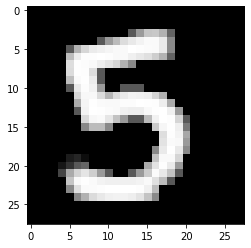

In [324]:
def validationData():
  image_name = '5_2.bmp'
  path_image = f'{path_folder}/{image_name}'
  image_stream = open(path_image,"rb")
  ba = bytearray(image_stream.read())
  pixels = np.flip(np.array(ba[len(ba)-784:]).reshape((28, 28)), 0)
  plt.imshow(pixels, cmap='gray')
  x = pixels.reshape((784,1))
  result = net.sigmoid(np.dot(net.weights[0], x) + net.biases[0])
  result = net.sigmoid(np.dot(net.weights[1], result) + net.biases[1])
  result = np.argmax(result)
  print(result)

  plt.show()
validationData()

In [0]:
def draw(input, label, output):
  image = np.reshape(input, (28, 28))
  image = np.array(image, dtype='float')
  pixels = image.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()
  print("{0} - {1}".format(label, output))

        draw(test_data[0][0], test_data[0][1], self.evaluate(test_data))